### Code Hist.

 - CODE  
    &ensp; : Model - KIER Method 02(Clustering)

  - DATE      &ensp; 2023-03-05 Created  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) Dataset : KIER / KMA_ASOS    
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2) Model : LightGBM  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 3)   

 - Related Link  
    &ensp; : 

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [86]:
#region Basic_Import
## Basic
import os
os.path.dirname(os.path.abspath('__file__'))
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import math
import random

## Datetime
import time
import datetime as dt
from datetime import datetime, date, timedelta

import glob
from glob import glob
import requests
import json

## 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

# K-Means 알고리즘
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split

# CLustering 알고리즘의 성능 평가 측도
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, silhouette_score, rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix

## 정규화
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics

import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## Init.
pd.options.display.float_format = '{:.10f}'.format
#endregion Basic_Import

In [2]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch
    import torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf
    import tensorflow_addons as tfa
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [3]:
# !pip install catboost

## LGBM
from catboost import Pool, CatBoostRegressor

# !pip install lightgbm

## LGBM
import lightgbm as lgbm
from lightgbm import LGBMRegressor

## LSTM
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
## Import_Local
from Src_Dev_Common import DEV_Common_Data_Datetime as com_date
from Src_Dev_Common import DEV_KASI_Holiday as com_Holi
from Src_Dev_Common import DEV_Common_Data_Analysis as com_Analysis
from Src_Dev_Common import DEV_Common_Data_Preprocessing as com_Prep
from Src_Dev_Common import DEV_Common_Data_Visualization as com_Visual
from Src_Dev_Common import DEV_KMA_Weather_ASOS as com_ASOS
from Src_Dev_Common import DEV_KDHC_Usage as com_KDHC
from Src_Dev_Common import DEV_KIER_Usage as com_KIER

### 01-01-02. Config (Directory, Params)

In [5]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
random.seed(SEED)

In [6]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y = pd.datetime.now().year
str_now_m = pd.datetime.now().month
str_now_d = pd.datetime.now().day
str_now_hr = pd.datetime.now().hour
str_now_min = pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2024-03-11 09:05:07.392906
2024 / 3 / 11
9 : 5


In [7]:
## Dict_Domain
dict_domain = {0:"ELEC", 1:"HEAT", 2:"WATER", 3:"HOT_HEAT", 4:"HOT_FLOW", 99:"GAS"} ## GAS는 사용하지 않음.
int_domain = 0
str_domain = str(dict_domain[int_domain])

dict_col_accu = {0 : "ACTUAL_ACCU_EFF" ## ELEC
                 , 1 : "ACCU_HEAT" ## HEAT
                 , 2 : "ACCU_FLOW" ## WATER
                 , 3 : "ACCU_HEAT" ## HOT 열량
                 , 4 : "ACCU_FLOW" ## HOT 유량
                 , 99 : "ACCU_FLOW" ## GAS
                 }
str_col_accu = str(str_domain + "_" + str(dict_col_accu[int_domain]))

dict_col_inst = {0 : "INST_EFF" ## ELEC_ACCU/INST_EFF
                , 1 : "INST_HEAT" ## HEAT_ACCU/INST_HEAT
                , 2 : "INST_FLOW" ## WATER_ACCU/INST_FLOW
                , 3 : "INST_HEAT" ## HOT_ACCU/INST_HEAT
                , 4 : "INST_FLOW" ## HOT_ACCU/INST_FLOW
                , 99 : "INST_FLOW" ## GAS_ACCU/INST_FLOW
                } 
str_col_inst = str(str_domain + "_" + str(dict_col_inst[int_domain]))

## Directory Root
str_dirData = "../data/data_Energy_KIER/"
str_dir_raw = '../data/data_Energy_KIER/KIER_0_Raw/'
str_dirName_bld = '../data/data_Energy_KIER/KIER_1_BLD/'
str_dirName_f = '../data/data_Energy_KIER/KIER_2_F_' + str_domain + '/'
str_dirName_h = '../data/data_Energy_KIER/KIER_3_H_' + str_domain + '/'

## File
str_fileRaw = str('KIER_RAW_' + str_domain + '_2023-11-12.csv')
str_fileRaw_hList = str('KIER_hList_' + str_domain + '.csv')

print(str(os.listdir(str_dirData)) + "\n")
print(os.listdir(str_dirName_h))

['.ipynb_checkpoints', 'BS_CONFIGURATION_202309251452.csv', 'Data_Population_SJ_2014_2018_1st_Interpolated.csv', 'Data_Population_SJ_2014_2018_D_1st_Interpolated.csv', 'Data_Population_SJ_2014_2018_H_1st_Interpolated.csv', 'DATE_1M_2023-10-20.csv', 'ENV_SENSOR_HST_202309251452.csv', 'F1_MAIN_POWER_HST_202309251503.csv', 'F1_SUB_POWER_HST_202309251510.csv', 'HEATPUMP_HST_202309251520.csv', 'KIER_0_Raw', 'KIER_1_BLD', 'KIER_2_F_ELEC', 'KIER_2_F_GAS', 'KIER_2_F_HEAT', 'KIER_2_F_HOT', 'KIER_2_F_WATER', 'KIER_3_H_ELEC', 'KIER_3_H_GAS', 'KIER_3_H_HEAT', 'KIER_3_H_HOT', 'KIER_3_H_HOT_FLOW', 'KIER_3_H_HOT_HEAT', 'KIER_3_H_WATER', 'KIER_ASOS_WEATHER_DAILY_202309251521.csv', 'KIER_ASOS_WEATHER_HOUR_202309251521.csv', 'KIER_List_Table_Column_2023-09-25.xlsx', 'KIER_Query_2023-09-25.txt', 'KMA_ASOS_119_2010_2023_1st_to CSV.csv', 'LIGHT_HST_202309251523.csv', 'MACHINE_ROOM_HEAT_HST_202309251534.csv', 'MACHINE_ROOM_POWER_APT_HST_20221205_202309251617.csv', 'MACHINE_ROOM_POWER_APT_HST_20221205_202309

## 01-02. Data Load (df_raw)

### 01-02-01. KDHC Heat Usage (Intergrated)

In [8]:
## KMA_ASOS Data
str_dir_kmaAsos = "../data/data_KMA_ASOS/"

## Interpolate / Filled ASOS Data
str_file = 'ASOS_119_2010-2024_HR_INTP.csv'
Data_ASOS = pd.read_csv(str_dir_kmaAsos + str_file
                        , index_col = 0)
Data_ASOS['METER_DATE'] = pd.to_datetime(Data_ASOS['METER_DATE'])
Data_ASOS

,temp_outdoor,temp_dew_point,temp_ground,humidity,rainfall,snowfall,snowfall_3hr,wind_speed,wind_direction,pressure_vapor,...,solar_radiation,cloud_total,cloud_midlow,visual_range,YEAR,MONTH,DAY,HOUR,None,METER_DATE
0,-10.3000000000,-17.6000000000,-5.8000000000,55.0000000000,0.0000000000,0.5000000000,0.0000000000,1.6000000000,340.0000000000,1.5000000000,...,0.0000000000,0.0000000000,0.0000000000,2000.0000000000,2010,1,1,0,0,2010-01-01 00:00:00
1,-10.4000000000,-17.9000000000,-5.7000000000,54.0000000000,0.0000000000,0.5000000000,0.0000000000,0.3000000000,0.0000000000,1.5000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,2010,1,1,1,0,2010-01-01 01:00:00
2,-10.6000000000,-17.6000000000,-5.9000000000,56.0000000000,0.0000000000,0.5000000000,0.0000000000,0.6000000000,270.0000000000,1.5000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,2010,1,1,2,0,2010-01-01 02:00:00
3,-11.0000000000,-18.0000000000,-5.9000000000,56.0000000000,0.0000000000,0.5000000000,0.0000000000,1.5000000000,290.0000000000,1.5000000000,...,0.0000000000,0.0000000000,0.0000000000,2000.0000000000,2010,1,1,3,0,2010-01-01 03:00:00
4,-11.6000000000,-18.2000000000,-6.0000000000,58.0000000000,0.0000000000,0.5000000000,0.0000000000,0.9000000000,290.0000000000,1.5000000000,...,0.0000000000,0.0000000000,0.0000000000,2000.0000000000,2010,1,1,4,0,2010-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8656,2.1000000000,0.3000000000,-0.3000000000,88.0000000000,0.0000000000,0.0000000000,0.0000000000,0.5000000000,270.0000000000,6.2000000000,...,0.0000000000,0.0000000000,0.0000000000,2055.0000000000,2023,12,31,19,0,2023-12-31 19:00:00
8657,1.1000000000,0.0000000000,-0.3000000000,92.0000000000,0.0000000000,0.0000000000,0.0000000000,0.3000000000,0.0000000000,6.1000000000,...,0.0000000000,0.0000000000,0.0000000000,1447.0000000000,2023,12,31,20,0,2023-12-31 20:00:00
8658,0.0000000000,-0.7000000000,-0.4000000000,95.0000000000,0.0000000000,0.0000000000,0.0000000000,0.9000000000,270.0000000000,5.8000000000,...,0.0000000000,0.0000000000,0.0000000000,533.0000000000,2023,12,31,21,0,2023-12-31 21:00:00
8659,-0.5000000000,-1.0000000000,-0.6000000000,96.0000000000,0.0000000000,0.0000000000,0.0000000000,0.9000000000,230.0000000000,5.7000000000,...,0.0000000000,0.0000000000,0.0000000000,533.0000000000,2023,12,31,22,0,2023-12-31 22:00:00


In [146]:
## Cluster 기준 Interval
list_interval = ['10MIN', '1H', '1DAY', '1WEEK', '1MONTH']
str_interval = list_interval[0]
str_file_clustering = 'KIER_' + str(str_domain) + '_Labeled_' + str_interval + '.csv'
df_kier_h_cluster = pd.read_csv(str_dirName_h + str_file_clustering
                                , index_col = 0).rename(columns = {'index' : 'h_index'})[['h_index', 'target_' + str_domain]]
print(str_interval)
print(df_kier_h_cluster['target_' + str_domain].drop_duplicates())
df_kier_h_cluster

10MIN
0    1
2    0
Name: target_ELEC, dtype: int64


,h_index,target_ELEC
0,ELEC_INST_EFF_561-1-1,1
1,ELEC_INST_EFF_561-1-2,1
2,ELEC_INST_EFF_561-1-3,0
3,ELEC_INST_EFF_561-1-4,1
4,ELEC_INST_EFF_561-2-1,1
...,...,...
343,ELEC_INST_EFF_563-23-2,1
344,ELEC_INST_EFF_563-23-3,0
345,ELEC_INST_EFF_563-23-4,0
346,ELEC_INST_EFF_563-24-1,0


In [147]:
list_kier_h_all = df_kier_h_cluster['h_index']
print(len(list_kier_h_all))
list_kier_h_c0 = df_kier_h_cluster[df_kier_h_cluster['target_' + str_domain] == 0]['h_index']
print(len(list_kier_h_c0))
list_kier_h_c1 = df_kier_h_cluster[df_kier_h_cluster['target_' + str_domain] == 1]['h_index']
print(len(list_kier_h_c1))
list_kier_h_c2 = df_kier_h_cluster[df_kier_h_cluster['target_' + str_domain] == 2]['h_index']
print(len(list_kier_h_c2))

348
228
120
0


In [148]:
## 사용량 Data Load
## 1시간 단위
str_file = 'KIER_' + str_domain + '_INST_1H_InstBaseUpdated.csv'
df_raw = pd.read_csv(str_dirName_h + str_file
                     , index_col = 0)
df_raw = df_raw.drop(columns = ['METER_DATE'])
df_raw

,ELEC_INST_EFF_561-1-1,ELEC_INST_EFF_561-1-2,ELEC_INST_EFF_561-1-3,ELEC_INST_EFF_561-1-4,ELEC_INST_EFF_561-2-1,ELEC_INST_EFF_561-2-2,ELEC_INST_EFF_561-2-3,ELEC_INST_EFF_561-2-4,ELEC_INST_EFF_561-3-1,ELEC_INST_EFF_561-3-2,...,ELEC_INST_EFF_563-22-3,ELEC_INST_EFF_563-22-4,ELEC_INST_EFF_563-22-5,ELEC_INST_EFF_563-22-6,ELEC_INST_EFF_563-23-1,ELEC_INST_EFF_563-23-2,ELEC_INST_EFF_563-23-3,ELEC_INST_EFF_563-23-4,ELEC_INST_EFF_563-24-1,ELEC_INST_EFF_563-24-2
0,0.8600000000,1.2500000000,0.1700000000,1.0633876812,0.8600000000,0.2500000000,0.6000000000,0.4800000000,0.8100000000,0.3200000000,...,0.6000000000,0.6100000000,0.1900000000,0.2200000000,0.2200000000,0.3600000000,0.2600000000,0.2100000000,0.1600000000,0.4400000000
1,0.7277880265,1.1200000000,0.1800000000,0.9600000000,0.4500000000,0.2600000000,0.6000000000,0.4600000000,0.7100000000,0.4000000000,...,0.2349605523,0.4600000000,0.1600000000,0.2400000000,0.3100000000,0.4100000000,0.2500000000,0.2000000000,0.1400000000,0.3868823529
2,0.5012896426,0.9900000000,0.1900000000,0.8900000000,0.5800000000,0.2400000000,0.6300000000,0.4500000000,0.7000000000,0.2900000000,...,0.2100000000,0.2700000000,0.1600000000,0.2700000000,0.2500000000,0.3400000000,0.2600000000,0.2000000000,0.1300000000,0.2500000000
3,0.3300000000,1.0300000000,0.2000000000,1.0600000000,0.2700000000,0.1800000000,0.1400000000,0.2700000000,0.6100000000,0.4000000000,...,0.2000000000,0.2500000000,0.1400000000,0.2400000000,0.2100000000,0.3400000000,0.2600000000,0.1900000000,0.1400000000,0.2200000000
4,0.2600000000,1.0000000000,0.2700000000,0.8700000000,0.6200000000,0.1700000000,0.1300000000,0.2300000000,0.5700000000,0.2800000000,...,0.2100000000,0.2800000000,0.1300000000,0.3200000000,0.1900000000,0.4600000000,0.2800000000,0.1800000000,0.1800000000,0.3000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10786,0.4100000000,0.7500000000,0.4700000000,0.3000000000,0.3200000000,0.2200000000,0.1300000000,0.1500000000,0.4600000000,0.2200000000,...,0.1400000000,0.1500000000,0.6500000000,0.1700000000,0.3500000000,0.2600000000,0.2500000000,0.2700000000,0.3900000000,0.3200000000
10787,0.5000000000,0.7000000000,1.3200000000,0.3100000000,0.4000000000,0.2500000000,0.1100000000,0.3300000000,0.2200000000,0.2600000000,...,0.1600000000,0.1800000000,0.4200000000,0.2500000000,0.6100000000,0.2300000000,0.2900000000,0.3700000000,0.2200000000,0.3300000000
10788,0.4400000000,0.9000000000,0.3400000000,0.3100000000,0.6100000000,0.2000000000,0.1936887608,0.4200000000,0.2200000000,0.2200000000,...,0.1600000000,0.1700000000,0.6100000000,0.6900000000,0.5000000000,0.3000000000,0.2500000000,0.4400000000,0.1800000000,0.3800000000
10789,0.3175123564,0.7400000000,0.3100000000,0.2175123564,0.4175123564,0.2375123564,0.1675123564,0.3400000000,0.1975123564,0.2175123564,...,0.1675123564,0.1675123564,0.3300000000,0.4875123564,0.7875123564,0.2100000000,0.2000000000,0.2175123564,0.1675123564,0.2675123564


In [149]:
## 전체 사용량
df_kier_h_all = df_raw.copy()
## 0으로 표기되는 마지막행 제거
df_kier_h_all = df_kier_h_all[:-1]
print(df_kier_h_all.shape)

## Cluster별 사용량
## ■ C00
df_kier_h_c0 = df_raw.copy()[list_kier_h_c0]
df_kier_h_c0 = df_kier_h_c0[:-1]
print(df_kier_h_c0.shape)

## ■ C01
df_kier_h_c1 = df_raw.copy()[list_kier_h_c1]
df_kier_h_c1 = df_kier_h_c1[:-1]
print(df_kier_h_c1.shape)

## ■ C02
df_kier_h_c2 = df_raw.copy()[list_kier_h_c2]
df_kier_h_c2 = df_kier_h_c2[:-1]
print(df_kier_h_c2.shape)

(10790, 348)
(10790, 228)
(10790, 120)
(10790, 0)


In [150]:
df_kier_h_c0

,ELEC_INST_EFF_561-1-3,ELEC_INST_EFF_561-2-2,ELEC_INST_EFF_561-2-3,ELEC_INST_EFF_561-2-4,ELEC_INST_EFF_561-3-2,ELEC_INST_EFF_561-3-3,ELEC_INST_EFF_561-3-4,ELEC_INST_EFF_561-4-1,ELEC_INST_EFF_561-4-4,ELEC_INST_EFF_561-5-2,...,ELEC_INST_EFF_563-21-5,ELEC_INST_EFF_563-22-2,ELEC_INST_EFF_563-22-3,ELEC_INST_EFF_563-22-4,ELEC_INST_EFF_563-22-5,ELEC_INST_EFF_563-22-6,ELEC_INST_EFF_563-23-1,ELEC_INST_EFF_563-23-3,ELEC_INST_EFF_563-23-4,ELEC_INST_EFF_563-24-1
0,0.1700000000,0.2500000000,0.6000000000,0.4800000000,0.3200000000,0.2400000000,0.1600000000,0.4700000000,0.3700000000,0.2400000000,...,0.3300000000,0.3900000000,0.6000000000,0.6100000000,0.1900000000,0.2200000000,0.2200000000,0.2600000000,0.2100000000,0.1600000000
1,0.1800000000,0.2600000000,0.6000000000,0.4600000000,0.4000000000,0.2000000000,0.1400000000,0.3300000000,0.5500000000,0.1700000000,...,0.2000000000,0.3300000000,0.2349605523,0.4600000000,0.1600000000,0.2400000000,0.3100000000,0.2500000000,0.2000000000,0.1400000000
2,0.1900000000,0.2400000000,0.6300000000,0.4500000000,0.2900000000,0.2100000000,0.1400000000,0.3400000000,0.2200000000,0.1300000000,...,0.2100000000,0.2700000000,0.2100000000,0.2700000000,0.1600000000,0.2700000000,0.2500000000,0.2600000000,0.2000000000,0.1300000000
3,0.2000000000,0.1800000000,0.1400000000,0.2700000000,0.4000000000,0.2100000000,0.1300000000,0.3500000000,0.2200000000,0.1400000000,...,0.1800000000,0.1300000000,0.2000000000,0.2500000000,0.1400000000,0.2400000000,0.2100000000,0.2600000000,0.1900000000,0.1400000000
4,0.2700000000,0.1700000000,0.1300000000,0.2300000000,0.2800000000,0.2100000000,0.1300000000,0.3000000000,0.2200000000,0.1300000000,...,0.1900000000,0.1400000000,0.2100000000,0.2800000000,0.1300000000,0.3200000000,0.1900000000,0.2800000000,0.1800000000,0.1800000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10785,0.4200000000,0.2000000000,0.1200000000,0.1900000000,0.2200000000,0.1921472393,0.2600000000,0.3000000000,0.4000000000,0.2900000000,...,0.2100000000,0.4200000000,0.2371472393,0.1900000000,0.4300000000,0.2121472393,0.3221472393,0.2100000000,0.4700000000,0.3700000000
10786,0.4700000000,0.2200000000,0.1300000000,0.1500000000,0.2200000000,0.1500000000,0.2400000000,0.2400000000,0.2100000000,0.3200000000,...,0.1800000000,0.4800000000,0.1400000000,0.1500000000,0.6500000000,0.1700000000,0.3500000000,0.2500000000,0.2700000000,0.3900000000
10787,1.3200000000,0.2500000000,0.1100000000,0.3300000000,0.2600000000,0.1500000000,0.2600000000,0.3500000000,1.3100000000,0.1500000000,...,0.1700000000,0.6600000000,0.1600000000,0.1800000000,0.4200000000,0.2500000000,0.6100000000,0.2900000000,0.3700000000,0.2200000000
10788,0.3400000000,0.2000000000,0.1936887608,0.4200000000,0.2200000000,0.4800000000,0.2200000000,0.5400000000,1.3600000000,0.1500000000,...,0.1700000000,0.4500000000,0.1600000000,0.1700000000,0.6100000000,0.6900000000,0.5000000000,0.2500000000,0.4400000000,0.1800000000


## 01-06. Data Split (Train/Test Setting)

In [157]:
## 모든 세대
# df_raw = df_kier_h_all
# str_col_tar = str_domain + '_INST_SUM_ALL'
## C1 세대
# df_raw = df_kier_h_c0
# str_col_tar = str_domain + '_INST_SUM_C0'
## C2 세대
df_raw = df_kier_h_c1
str_col_tar = str_domain + '_INST_SUM_C1'
## C3 세대
# df_raw = df_kier_h_c2
# str_col_tar = str_domain + '_INST_SUM_C2'

In [158]:
## 군집 내 모든 값의 분산
df_concatnated = pd.DataFrame()
int_cnt = 0
for tar_col in df_raw.columns:
    # print(tar_col)
    df_temp = df_raw[[tar_col]].copy()
    df_temp = df_temp.rename(columns = {tar_col : "Usage"})

    if int_cnt == 0:
        df_concatnated = df_temp.copy()
    else:
        df_concatnated = pd.concat([df_concatnated, df_temp])

    int_cnt = int_cnt + 1

# print("Var : ", np.var(df_concatnated["Usage"]))
print("Max : ", np.max(df_concatnated["Usage"]))
print("75 : ", np.percentile(df_concatnated["Usage"], 75))
# print("Mean : ", np.mean(df_concatnated["Usage"]))
print("Med : ", np.median(df_concatnated["Usage"]))
print("25 : ", np.percentile(df_concatnated["Usage"], 25))
print("Min : ", np.min(df_concatnated["Usage"]))


print(stats.describe(df_concatnated))
print("Std : ", np.std(df_concatnated["Usage"]))

Max :  5.949999999999818
75 :  0.6099999999996726
Med :  0.4099999999998545
25 :  0.287617187501155
Min :  0.0
DescribeResult(nobs=1294800, minmax=(array([0.]), array([5.95])), mean=array([0.50748899]), variance=array([0.1231684]), skewness=array([2.42027679]), kurtosis=array([9.01806588]))
Std :  0.35095342125670276


In [159]:
df_raw.isna().sum()

ELEC_INST_EFF_561-1-1     0
ELEC_INST_EFF_561-1-2     0
ELEC_INST_EFF_561-1-4     0
ELEC_INST_EFF_561-2-1     0
ELEC_INST_EFF_561-3-1     0
                         ..
ELEC_INST_EFF_563-21-4    0
ELEC_INST_EFF_563-21-6    0
ELEC_INST_EFF_563-22-1    0
ELEC_INST_EFF_563-23-2    0
ELEC_INST_EFF_563-24-2    0
Length: 120, dtype: int64

In [160]:
from sklearn.manifold import TSNE

## 표현할 데이터 차원
n_components = 2

## t-sne Model
model = TSNE(n_components = n_components)

## 학습 결과
res_tsne = model.fit_transform(df_raw)
print(res_tsne)

[[ 12.928301  -40.470654 ]
 [  6.3062844 -42.86325  ]
 [-11.5585785 -35.920673 ]
 ...
 [-47.422672   50.085278 ]
 [-47.44078    50.085636 ]
 [-34.645683    2.1358016]]


In [161]:
print(res_tsne[0])

[ 12.928301 -40.470654]


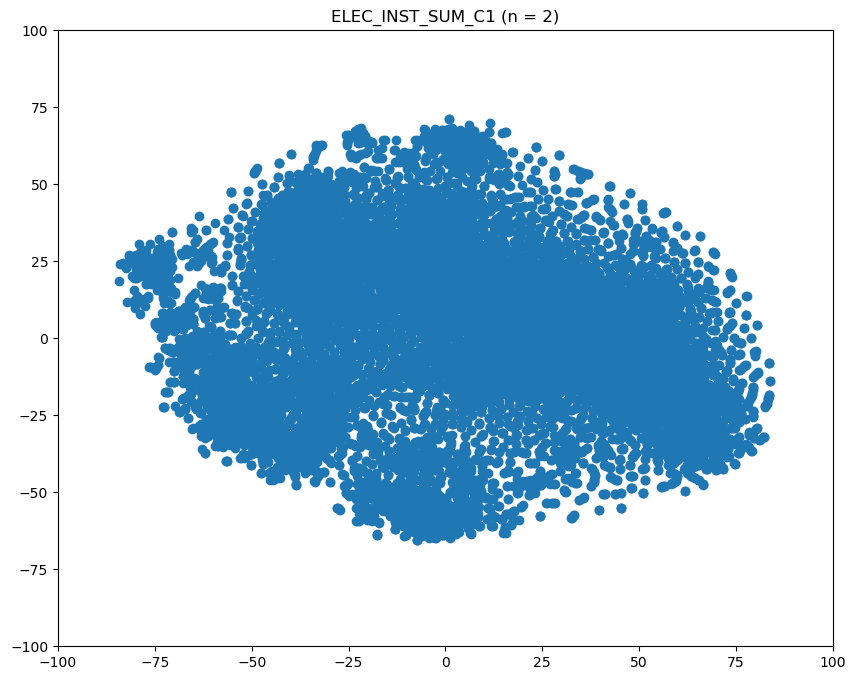

In [162]:
if n_components == 2:
    ## 2차원
    plt.scatter(res_tsne[:, 0], res_tsne[:, 1])
elif n_components == 3:
    ## 3차원
    plt.scatter(res_tsne[:, 0], res_tsne[:, 1], res_tsne[:, 2])

plt.title(str(str_col_tar + " (n = " + str(n_components) + ")"))

## 비교를 위한 범위 지정
plt.xlim([-100, 100])
plt.ylim([-100, 100])
plt.show()